Authors:

Lijing Wang (lijing52@stanford.edu)

Alex Miltenberger (ammilten@stanford.edu, ammilten@gmail.com)

June, 2022


In [1]:
from scipy.constants import G, pi
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib

import scipy.stats as st

from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
import seaborn as sns

np.random.seed(1)


In [2]:
x = np.linspace(-200,200,21)

def g(m):
    rho = m[:,0][:,np.newaxis]
    a = m[:,1][:,np.newaxis]
    z = m[:,2][:,np.newaxis]    
    
    gz = (4/3)*G*np.pi*(a**3)*rho*z / np.power((x**2+z**2),(3/2)) * 1e5
    return gz  


def sample(distr, N, kind=None):
    
    if kind == 'multivariate':
        samples = distr.rvs(N)
        
    elif kind == 'list':
        samples = [distr[i].rvs(N) for i in range(len(distr))]
        samples = np.vstack(samples).T
        
    elif kind == 'kde':
        samples = distr.resample(N).T
        
    else:
        print('DID NOT RECOGNIZE TYPE')   
        
    return samples

def BayesFactor(push_numerator, push_denominator, obs, N):
    # Sample push_numerator (m)
    
    # Sample push_denominator (m)
    
    # Forward simulation
    
    # Run both samples through obs (d)
    
    # Return B = Mean obs 1 / Mean obs 2
    
    pass
        

def SMC(initial_proposal, measurement_density, numIter, Nsamples, KDEsamples=None):
    '''
    initial_proposal: list of scipy.stats.rv_continuous or scipy.stats.gaussian_kde
    measurement_density: scipy.stats.rv_continuous
    Niter: 
    Nsamples:
    KDEsamples: number of samples for KDE estimation
    '''
    
    # Initialize proposal
    proposal = initial_proposal
    proposal_type = 'list'
    
    # Sample measurement density
    d_obs_samples = sample(measurement_density, Nsamples, kind='multivariate')
    
    if KDEsamples is None:
        KDEsamples = 2000
        
    output = {
        'm_samples':[], 
        'd_samples':[], 
        'S_samples':[],
        'pca':[],
        'weights':[],
        'proposal':[],
        'd_obs_samples':[],
        'S_obs_samples':[]
    }
    
    Iter = 0
    while Iter < numIter:
        print('Iteration {}'.format(Iter+1))
        # Sampling & fowrard model
        m_prop_samples = sample(proposal, Nsamples, kind=proposal_type)
        d_prop_samples = g(m_prop_samples)
        
        # PCA to create S (summary stat. function)
        pca = PCA(n_components=2).fit(d_prop_samples)
        S_prop_samples = pca.transform(d_prop_samples)
        S_obs_samples = pca.transform(d_obs_samples)
        
        # Low-dim density estimation        
        S_prop_density = st.gaussian_kde(S_prop_samples[:KDEsamples,:].T)
        S_obs_density = st.gaussian_kde(S_obs_samples[:KDEsamples,:].T)
    
        # Weights & proposal updating
        weights = S_obs_density.evaluate(S_prop_samples.T) / S_prop_density.evaluate(S_prop_samples.T)
        proposal = st.gaussian_kde(m_prop_samples.T, weights=weights, bw_method='silverman')
        
        Iter += 1
        proposal_type = 'kde'
        
        output['m_samples'].append(m_prop_samples)
        output['d_samples'].append(d_prop_samples)
        output['S_samples'].append(S_prop_samples)
        output['d_obs_samples'].append(d_obs_samples)
        output['S_obs_samples'].append(S_obs_samples)
        output['weights'].append(weights)
        output['proposal'].append(proposal)
        output['pca'].append(pca)
        
    return proposal, output

def Rejection(proposal, target, N, maxIter_factor=5, kind='kde'):
    Nprop = N*maxIter_factor
    m_proposal_samples = sample(proposal, Nprop, kind='kde')
    d_proposal_samples = g(m_proposal_samples)
    
    p_proposal_samples = target.pdf(d_proposal_samples)
    pmax = np.max(p_proposal_samples)
    p_proposal_samples = p_proposal_samples / pmax
    
    u = np.random.rand(Nprop)
    inds = p_proposal_samples > u
    
    m_samples = m_proposal_samples[inds,:]
    acc_rate = m_samples.shape[0] / Nprop
    print()
    
    if m_samples.shape[0] > N:
        print('Number of samples found: {} (only keeping fist {})'.format(m_samples.shape[0], N))
        m_samples = m_samples[:N,:]
    if m_samples.shape[0] < N:
        print('WARNING: only found {} samples (target samples = {})'.format(m_samples.shape[0], N))
    
    
    return m_samples, acc_rate
    


In [3]:
m_true = np.array([[2000, 100, 125]])

gz_obs_true = g(m_true)[0,:]

sigma = 0.05
gz_obs = st.multivariate_normal(mean=gz_obs_true, cov=np.diag((gz_obs_true*sigma)**2)).rvs(1)



In [4]:
initial_proposal = [st.uniform(loc=1000, scale=6000), st.uniform(loc=70, scale=130), st.uniform(loc=25, scale=175)]
measurement_density = st.multivariate_normal(mean=gz_obs, cov=np.diag((gz_obs*sigma)**2))
Niter = 3
Nsamples = 10000

posterior, S = SMC(initial_proposal, measurement_density, Niter, Nsamples, KDEsamples=Nsamples)



Iteration 1
Iteration 2
Iteration 3


In [5]:
prior_samples = sample(initial_proposal, Nsamples, kind='list')
posterior_samples = sample(posterior, Nsamples, kind='kde')
final_samples, acc_rate = Rejection(posterior, measurement_density, Nsamples, maxIter_factor=10)


obs_d = st.multivariate_normal.rvs(mean=gz_obs, cov=np.diag((sigma*gz_obs)**2), size=Nsamples)


Number of samples found: 21089 (only keeping fist 10000)


In [6]:
nn = Nsamples
cols = [r'$\rho$ (kg/m$^3$)',r'$a$ (m)',r'$z$ (m)']
final_samples_df = pd.DataFrame(final_samples[:nn], columns=cols)
prior_samples_df = pd.DataFrame(prior_samples[:nn], columns=cols)
posterior_samples_df = pd.DataFrame(posterior_samples[:nn,:], columns=cols)
true_df = pd.DataFrame(m_true, columns=cols)

sns.set(font_scale = 2)
sns.set_style(style='white')

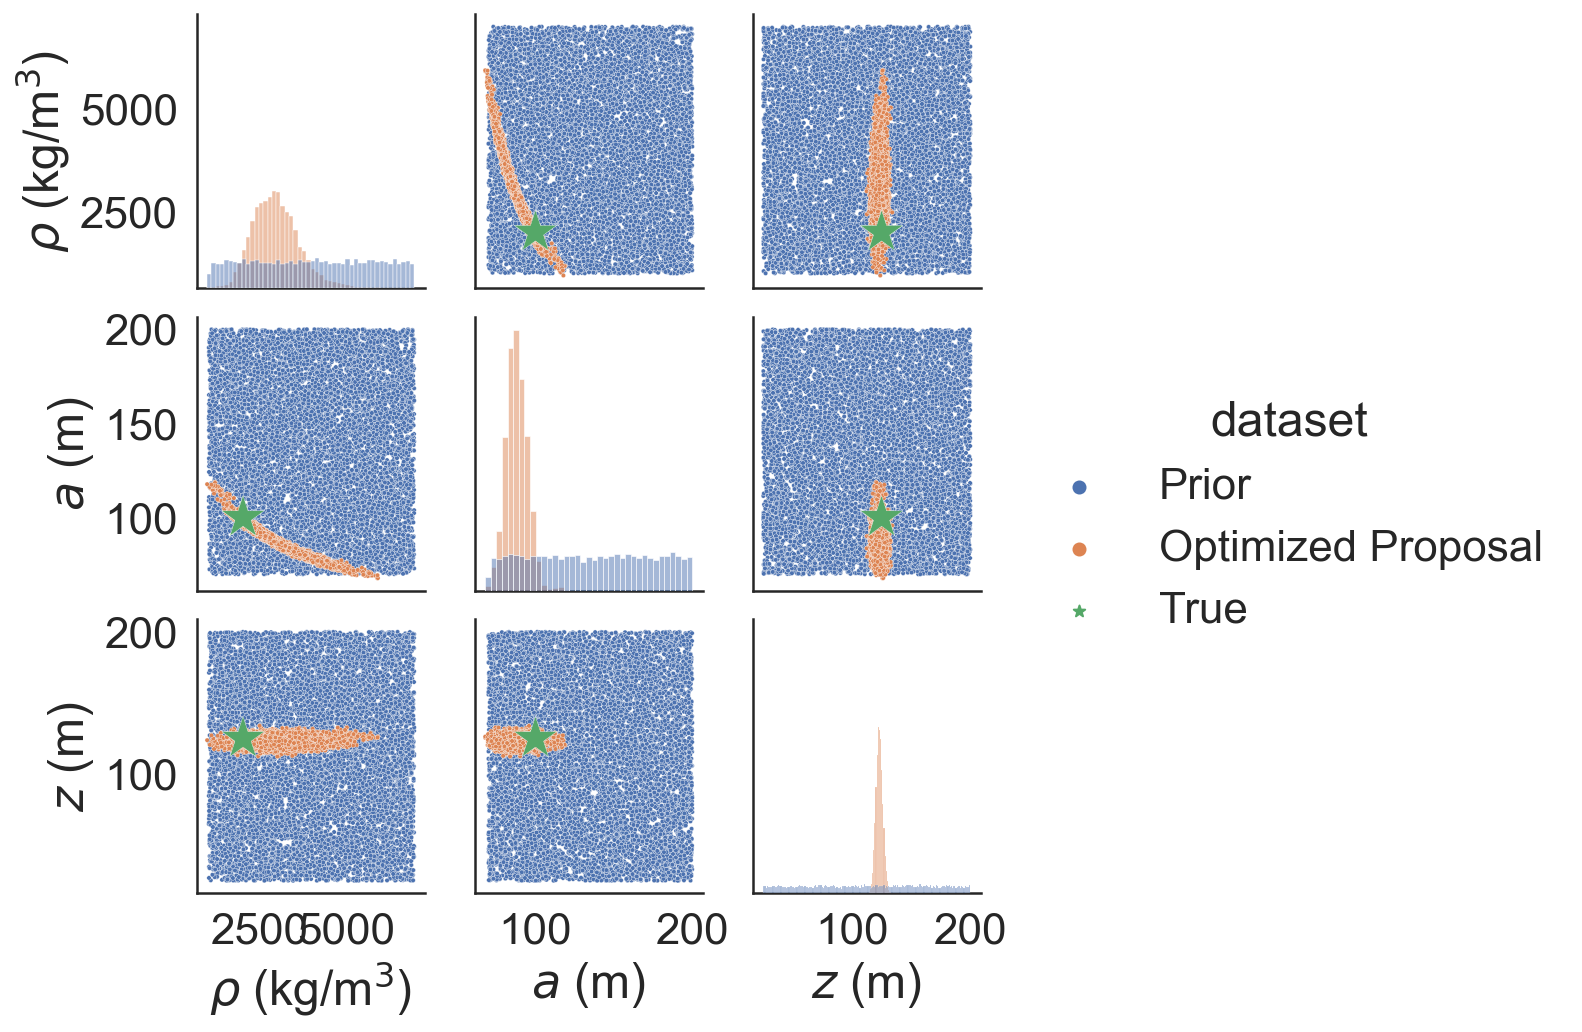

In [7]:
combined = pd.concat([
    prior_samples_df.assign(dataset='Prior', size=5, marker='o'),
    posterior_samples_df.assign(dataset='Optimized Proposal', size=5, marker='o'), 
#     final_samples_df.assign(dataset='Rejection', size=5, marker='o'),
    true_df.assign(dataset='True', size=500, marker='*')     
])
markers = {'Prior': 'o', 'Optimized Proposal': 'o', 'Rejection': 'o', 'True': '*'}
# sizes = {'Prior': 5, 'Proposal': 5, 'Rejection': 5, 'True': 500}

h = sns.pairplot(combined[cols+['dataset']], kind = 'scatter', diag_kind='hist', plot_kws={"s": combined['size']}, markers=markers, hue="dataset")



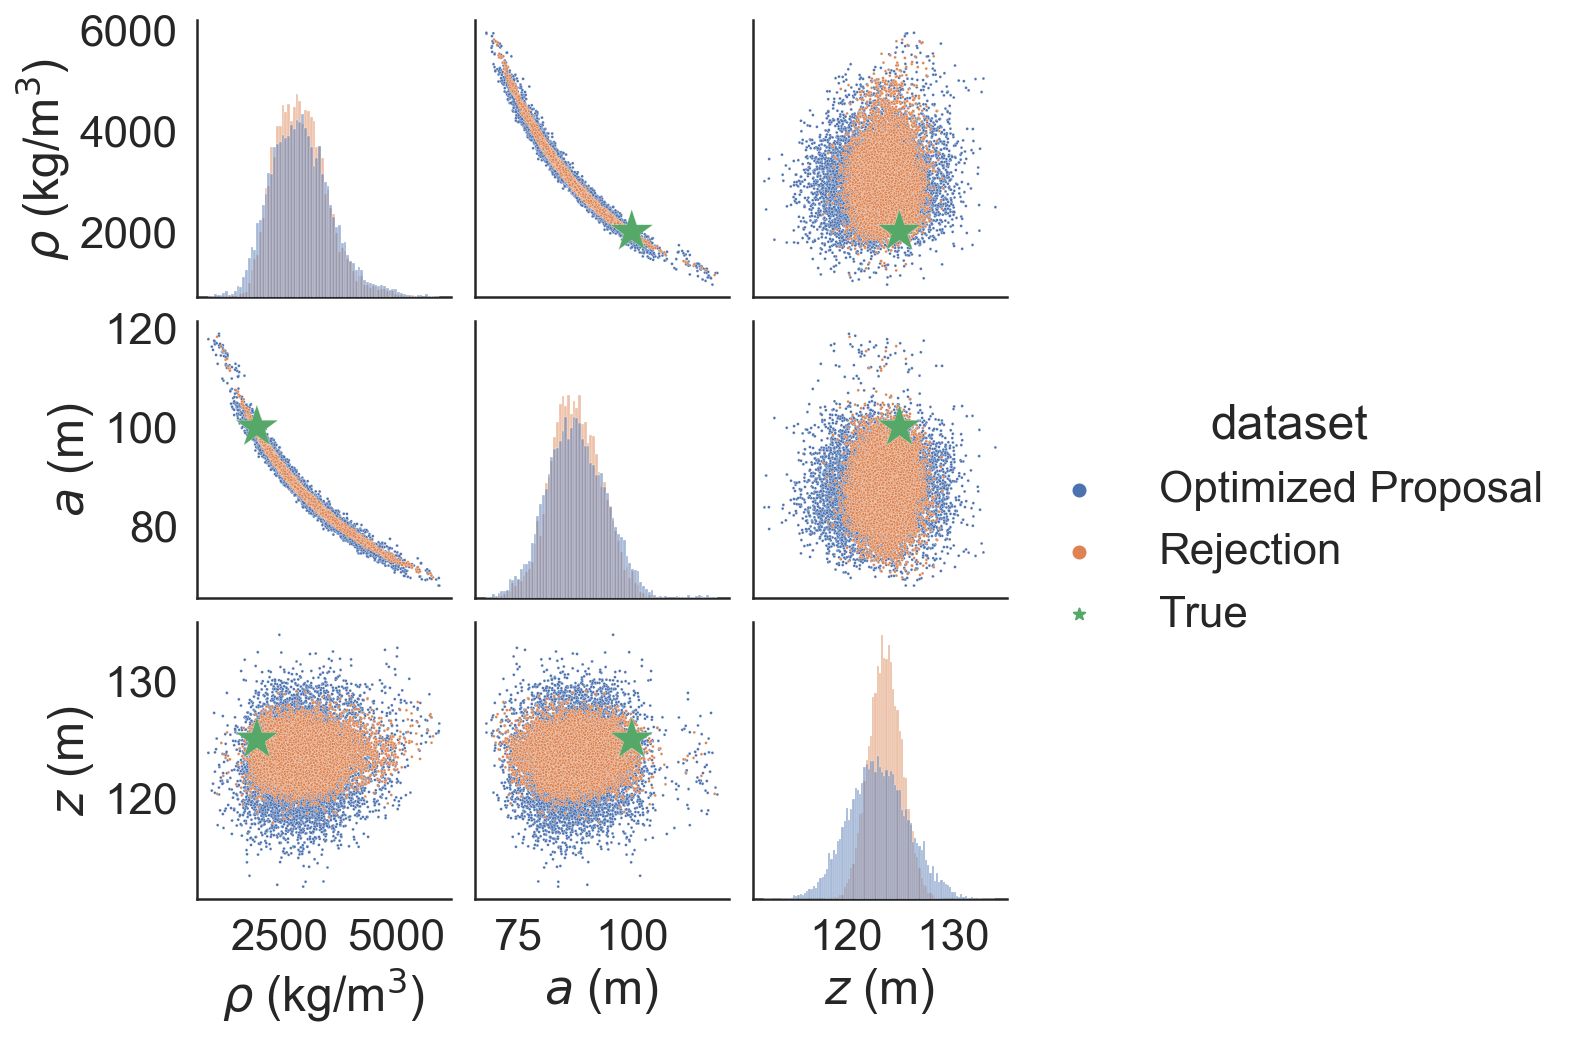

In [8]:
combined = pd.concat([
    posterior_samples_df.assign(dataset='Optimized Proposal', size=2, marker='o'), 
    final_samples_df.assign(dataset='Rejection', size=2, marker='o'),
    true_df.assign(dataset='True', size=500, marker='*')  
])

h = sns.pairplot(combined[cols + ['dataset']], kind = 'scatter', diag_kind='hist', plot_kws={"s": combined['size']}, markers=markers, hue="dataset")


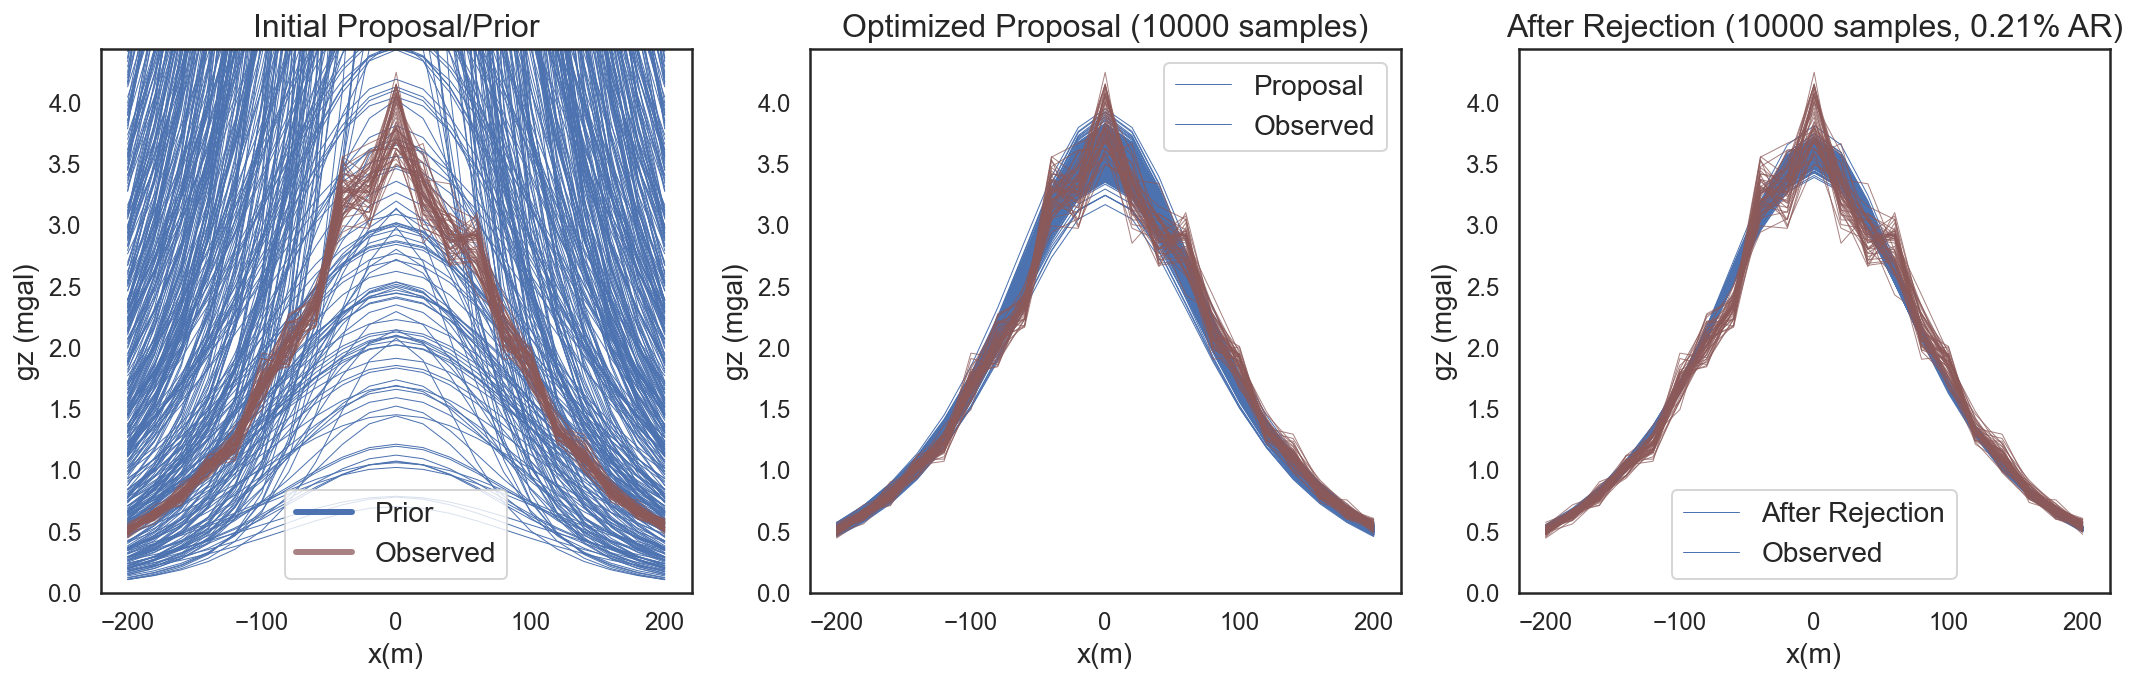

In [9]:
prior_data = g(prior_samples)
posterior_data = g(posterior_samples)
final_data = g(final_samples)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

axs[0].plot(x,prior_data[:500,:].T,color= 'C0', linewidth=0.5)
p1 = axs[0].plot(x,prior_data[0,:].T,color= 'C0', linewidth=0.5, label='Prior')
axs[0].plot(x,obs_d[:50,:].T,'-',color = [0.55, 0.35, 0.35, 0.75], linewidth=0.5)
p2 = axs[0].plot(x,obs_d[0,:].T,'-',color = [0.55, 0.35, 0.35, 0.75], linewidth=0.5, label='Observed')
axs[0].set_xlabel('x(m)', fontsize=14)
axs[0].set_ylabel('gz (mgal)', fontsize=14)
axs[0].set_title('Initial Proposal/Prior', fontsize=16)
axs[0].tick_params(labelsize=12)
leg = axs[0].legend(fontsize=14)
for L in leg.get_lines():
    L.set_linewidth(3)

    
axs[1].plot(x,posterior_data[:500,:].T,color= 'C0', linewidth=0.5)
axs[1].plot(x,obs_d[:50,:].T,'-',color = [0.55, 0.35, 0.35, 0.75], linewidth=0.5)
axs[1].set_xlabel('x(m)', fontsize=14)
axs[1].set_ylabel('gz (mgal)', fontsize=14)
axs[1].set_title('Optimized Proposal ({} samples)'.format(posterior_data.shape[0]), fontsize=16)
axs[1].tick_params(labelsize=12)
axs[1].legend(['Proposal', 'Observed'], fontsize=14)

axs[2].plot(x,final_data[:500,:].T,color= 'C0', linewidth=0.5)
axs[2].plot(x,obs_d[:50,:].T,'-',color = [0.55, 0.35, 0.35, 0.75], linewidth=0.5)
axs[2].set_xlabel('x(m)', fontsize=14)
axs[2].set_ylabel('gz (mgal)', fontsize=14)
axs[2].set_title('After Rejection ({} samples, {:.2f}% AR)'.format(final_data.shape[0], acc_rate), fontsize=16)
axs[2].tick_params(labelsize=12)
axs[2].legend(['After Rejection', 'Observed'], fontsize=14)

yl = axs[1].get_ylim()
yl = [0, yl[1]]
axs[0].set_ylim(yl);
axs[1].set_ylim(yl);
axs[2].set_ylim(yl);

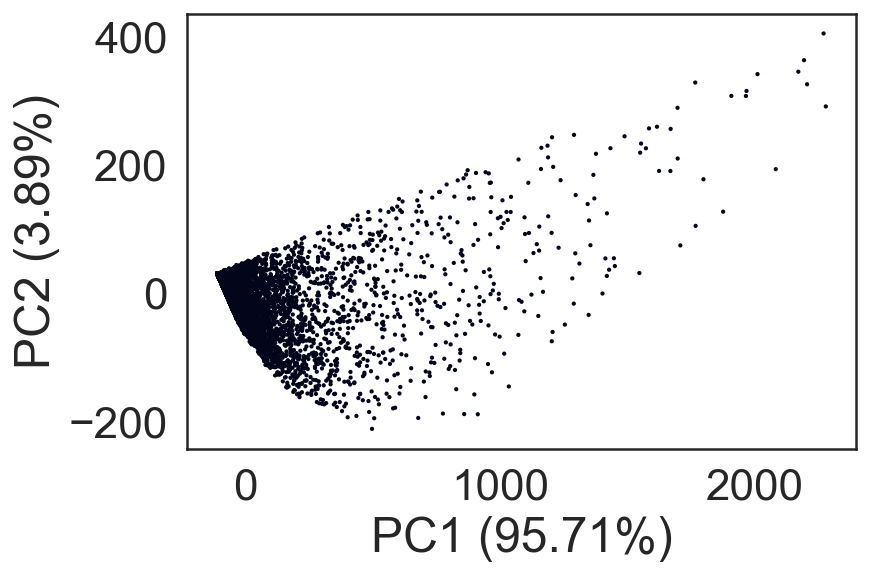

In [10]:
plt.scatter(S['S_samples'][0][:,0], S['S_samples'][0][:,1], 5, c=S['weights'][0], marker='.')
# plt.scatter(S['obs'][:1000,0], S['obs'][:1000,1], 100, marker='*',c='y', edgecolor='k', linewidth=1)
plt.xlabel('PC1 ({:.2%})'.format(S['pca'][0].explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.2%})'.format(S['pca'][0].explained_variance_ratio_[1]))
xl = plt.xlim()
yl = plt.ylim()
# plt.ylim([-0.02, 0.01])
# plt.xlim([-0.01,0.05])

# Paper Figures

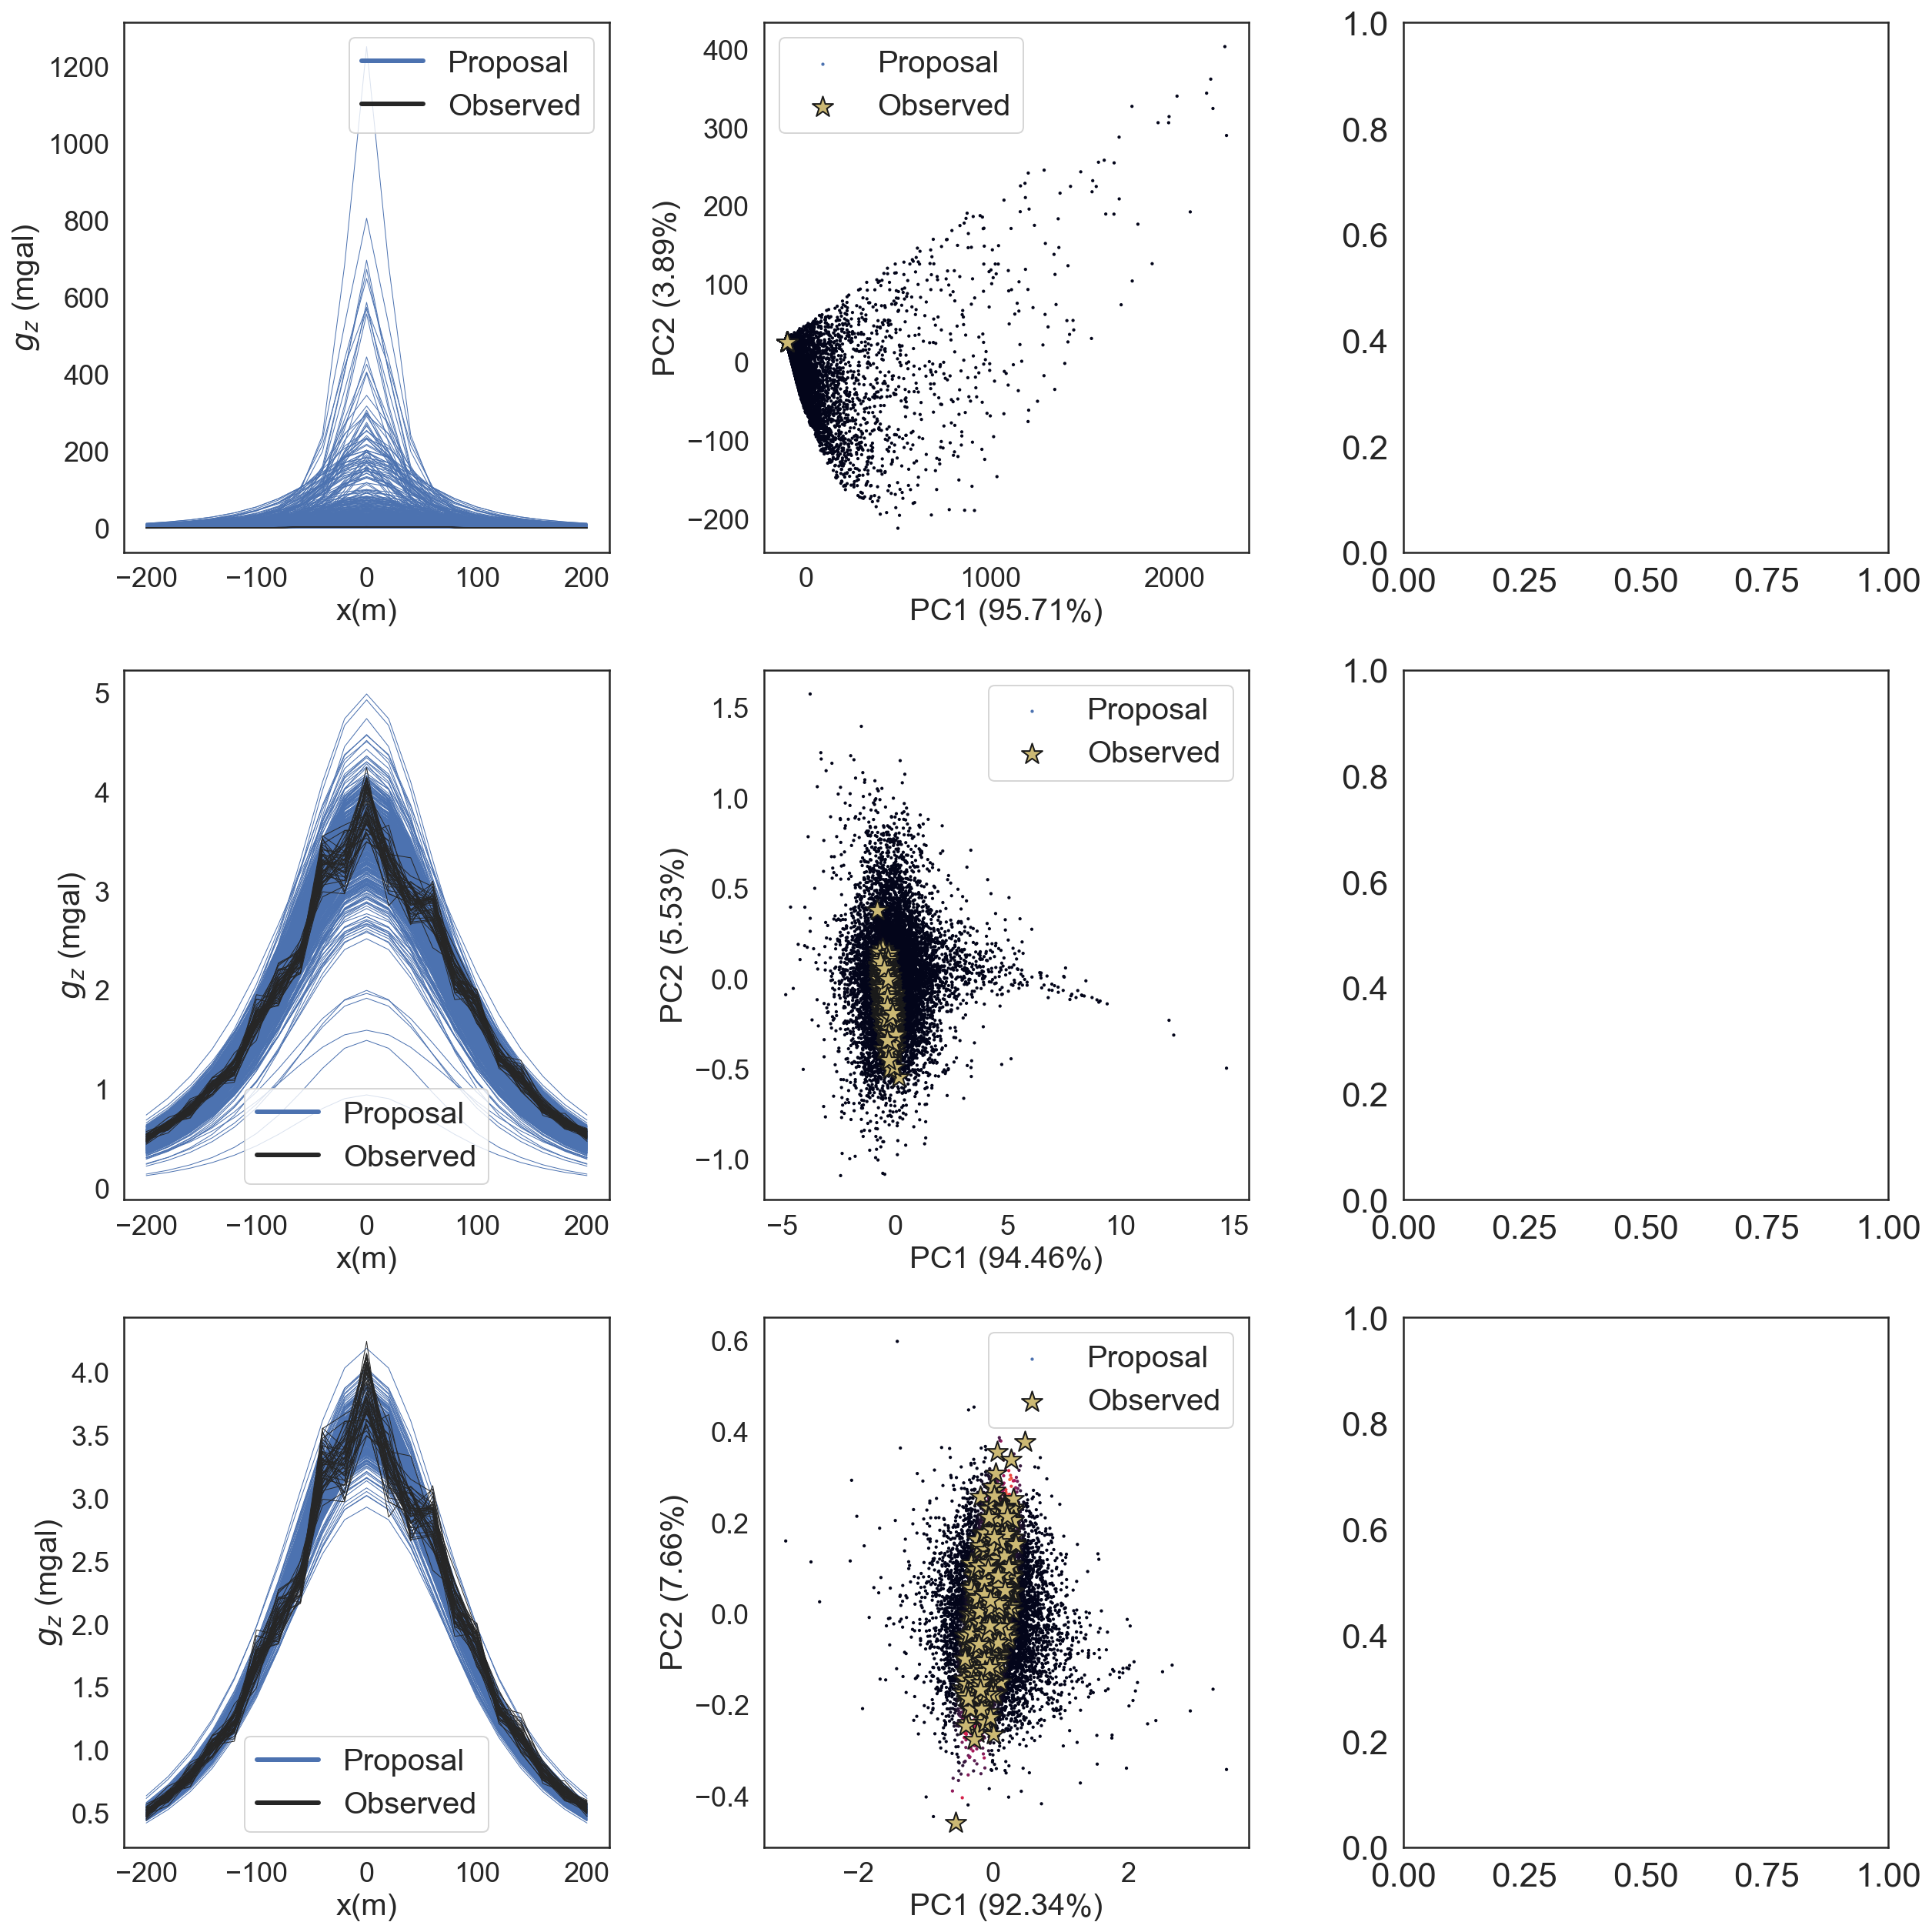

In [11]:
fs = 20
ts = 18

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18,18))

axs[0,0].plot(x,prior_data[:500,:].T,color= 'C0', linewidth=0.5)
p1 = axs[0,0].plot(x,prior_data[0,:].T,color= 'C0', linewidth=0.5, label='Proposal')
axs[0,0].plot(x,obs_d[:50,:].T,'-',color = [0.15, 0.15, 0.15, 1], linewidth=0.5)
p2 = axs[0,0].plot(x,obs_d[0,:].T,'-',color = [0.15, 0.15, 0.15, 1], linewidth=0.5, label='Observed')
axs[0,0].set_xlabel('x(m)', fontsize=fs)
axs[0,0].set_ylabel(r'$g_z$ (mgal)', fontsize=fs)
# axs[0,0].set_title('Proposal', fontsize=16)
axs[0,0].tick_params(labelsize=ts)
leg = axs[0,0].legend(fontsize=fs)
for L in leg.get_lines():
    L.set_linewidth(3)
    
axs[0,1].scatter(S['S_samples'][0][:,0], S['S_samples'][0][:,1], 5, c=S['weights'][0], marker='.', label='Proposal')
axs[0,1].scatter(S['S_obs_samples'][0][:1000,0], S['S_obs_samples'][0][:1000,1], 200, marker='*',c='y', edgecolor='k', label='Observed')
axs[0,1].set_xlabel('PC1 ({:.2%})'.format(S['pca'][0].explained_variance_ratio_[0]), fontsize=fs)
axs[0,1].set_ylabel('PC2 ({:.2%})'.format(S['pca'][0].explained_variance_ratio_[1]), fontsize=fs)
axs[0,1].tick_params(labelsize=ts)
axs[0,1].legend(fontsize=fs)


axs[1,0].plot(x,S['d_samples'][1][:500,:].T,color= 'C0', linewidth=0.5)
p1 = axs[1,0].plot(x,S['d_samples'][1][0,:].T,color= 'C0', linewidth=0.5, label='Proposal')
axs[1,0].plot(x,obs_d[:50,:].T,'-',color = [0.15, 0.15, 0.15, 1], linewidth=0.5)
p2 = axs[1,0].plot(x,obs_d[0,:].T,'-',color = [0.15, 0.15, 0.15, 1], linewidth=0.5, label='Observed')
axs[1,0].set_xlabel('x(m)', fontsize=fs)
axs[1,0].set_ylabel(r'$g_z$ (mgal)', fontsize=fs)
# axs[1,0].set_title('Proposal', fontsize=16)
axs[1,0].tick_params(labelsize=ts)
leg = axs[1,0].legend(fontsize=fs)
for L in leg.get_lines():
    L.set_linewidth(3)
    
axs[1,1].scatter(S['S_samples'][1][:,0], S['S_samples'][1][:,1], 5, c=S['weights'][1], marker='.', label='Proposal')
axs[1,1].scatter(S['S_obs_samples'][1][:1000,0], S['S_obs_samples'][1][:1000,1], 200, marker='*',c='y', edgecolor='k', label='Observed')
axs[1,1].set_xlabel('PC1 ({:.2%})'.format(S['pca'][1].explained_variance_ratio_[0]), fontsize=fs)
axs[1,1].set_ylabel('PC2 ({:.2%})'.format(S['pca'][1].explained_variance_ratio_[1]), fontsize=fs)
axs[1,1].tick_params(labelsize=ts)
axs[1,1].legend(fontsize=fs)

it = 2
axs[2,0].plot(x,S['d_samples'][it][:500,:].T,color= 'C0', linewidth=0.5)
p1 = axs[2,0].plot(x,S['d_samples'][it][0,:].T,color= 'C0', linewidth=0.5, label='Proposal')
axs[2,0].plot(x,obs_d[:50,:].T,'-',color = [0.15, 0.15, 0.15, 1], linewidth=0.5)
p2 = axs[2,0].plot(x,obs_d[0,:].T,'-',color = [0.15, 0.15, 0.15, 1], linewidth=0.5, label='Observed')
axs[2,0].set_xlabel('x(m)', fontsize=fs)
axs[2,0].set_ylabel(r'$g_z$ (mgal)', fontsize=fs)
# axs[2,0].set_title('Proposal', fontsize=16)
axs[2,0].tick_params(labelsize=ts)
leg = axs[2,0].legend(fontsize=fs)
for L in leg.get_lines():
    L.set_linewidth(3)
    
axs[2,1].scatter(S['S_samples'][it][:,0], S['S_samples'][it][:,1], 5, c=S['weights'][it], marker='.', label='Proposal')
axs[2,1].scatter(S['S_obs_samples'][it][:1000,0], S['S_obs_samples'][it][:1000,1], 200, marker='*',c='y', edgecolor='k', label='Observed')
axs[2,1].set_xlabel('PC1 ({:.2%})'.format(S['pca'][it].explained_variance_ratio_[0]), fontsize=fs)
axs[2,1].set_ylabel('PC2 ({:.2%})'.format(S['pca'][it].explained_variance_ratio_[1]), fontsize=fs)
axs[2,1].tick_params(labelsize=ts)
axs[2,1].legend(fontsize=fs)
    
# axs[1].plot(x,posterior_data[:500,:].T,color= 'C0', linewidth=0.5)
# axs[1].plot(x,obs_d[:50,:].T,'-',color = [0.55, 0.35, 0.35, 0.75], linewidth=0.5)
# axs[1].set_xlabel('x(m)', fontsize=14)
# axs[1].set_ylabel('gz (mgal)', fontsize=14)
# axs[1].set_title('Optimized Proposal ({} samples)'.format(posterior_data.shape[0]), fontsize=16)
# axs[1].tick_params(labelsize=12)
# axs[1].legend(['Proposal', 'Observed'], fontsize=14)

# axs[2].plot(x,final_data[:500,:].T,color= 'C0', linewidth=0.5)
# axs[2].plot(x,obs_d[:50,:].T,'-',color = [0.55, 0.35, 0.35, 0.75], linewidth=0.5)
# axs[2].set_xlabel('x(m)', fontsize=14)
# axs[2].set_ylabel('gz (mgal)', fontsize=14)
# axs[2].set_title('After Rejection ({} samples, {:.2f}% AR)'.format(final_data.shape[0], acc_rate), fontsize=16)
# axs[2].tick_params(labelsize=12)
# axs[2].legend(['After Rejection', 'Observed'], fontsize=14)

# yl = axs[1].get_ylim()
# yl = [0, yl[1]]
# axs[0].set_ylim(yl);
# axs[1].set_ylim(yl);
# axs[2].set_ylim(yl);

fig.tight_layout()

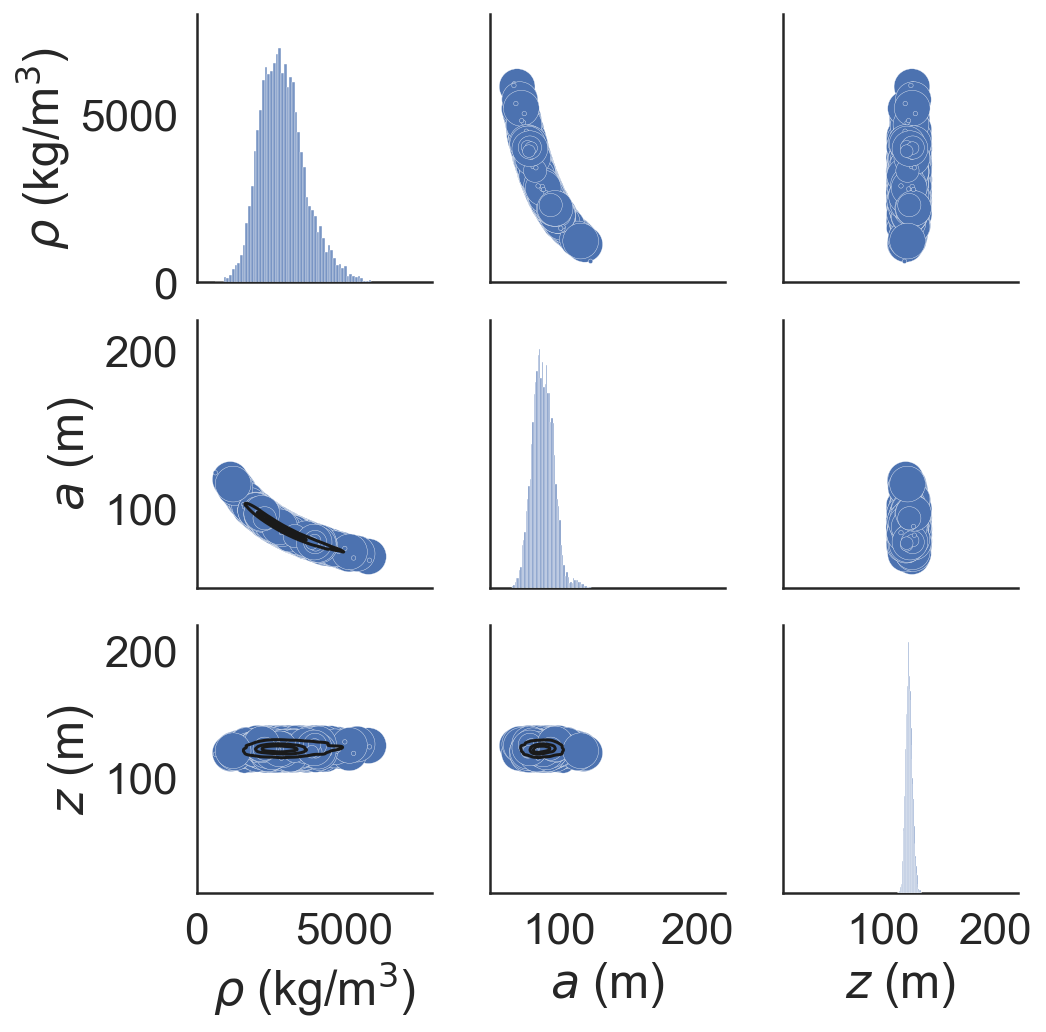

In [12]:
# Plot m-space with weights
t = 2

def create_label(lower, upper):
    lbl = '{:.2f} - {:.2f}'.format(lower, upper)
    return lbl

samples_df = pd.DataFrame(S['m_samples'][t], columns=cols)

bins = np.linspace(np.min(S['weights'][t]),np.max(S['weights'][t])*1.01,5)
binned = np.digitize(S['weights'][t], bins)
lbls = [create_label(bins[i],bins[i+1]) for i in range(bins.shape[0]-1)]
lbls2 = [None] * binned.shape[0]

for i in range(binned.shape[0]):
    lbls2[i] = lbls[binned[i]-1]

combined = pd.concat([
    samples_df.assign(dataset='iteration {}'.format(t), weights=lbls2, size=(binned**3)*5, marker='o'),
])
# markers = {'Prior': 'o', 'Optimized Proposal': 'o', 'Rejection': 'o', 'True': '*'}

h = sns.pairplot(
    combined[cols+['weights']], 
    kind = 'scatter', 
    diag_kind='hist', 
    diag_kws={'hue':None},
    plot_kws={"s": combined['size']}
#     hue="weights"
)
h.map_lower(sns.kdeplot, weights=S['weights'][t], levels=4, color='k')

h.axes[0,1].set_ylim((0,8000))
h.axes[0,1].set_xlim((50,220))

h.axes[1,0].set_xlim((0,8000))
h.axes[1,0].set_ylim((50,220))

h.axes[0,2].set_xlim((10,220))
h.axes[2,0].set_ylim((10,220));



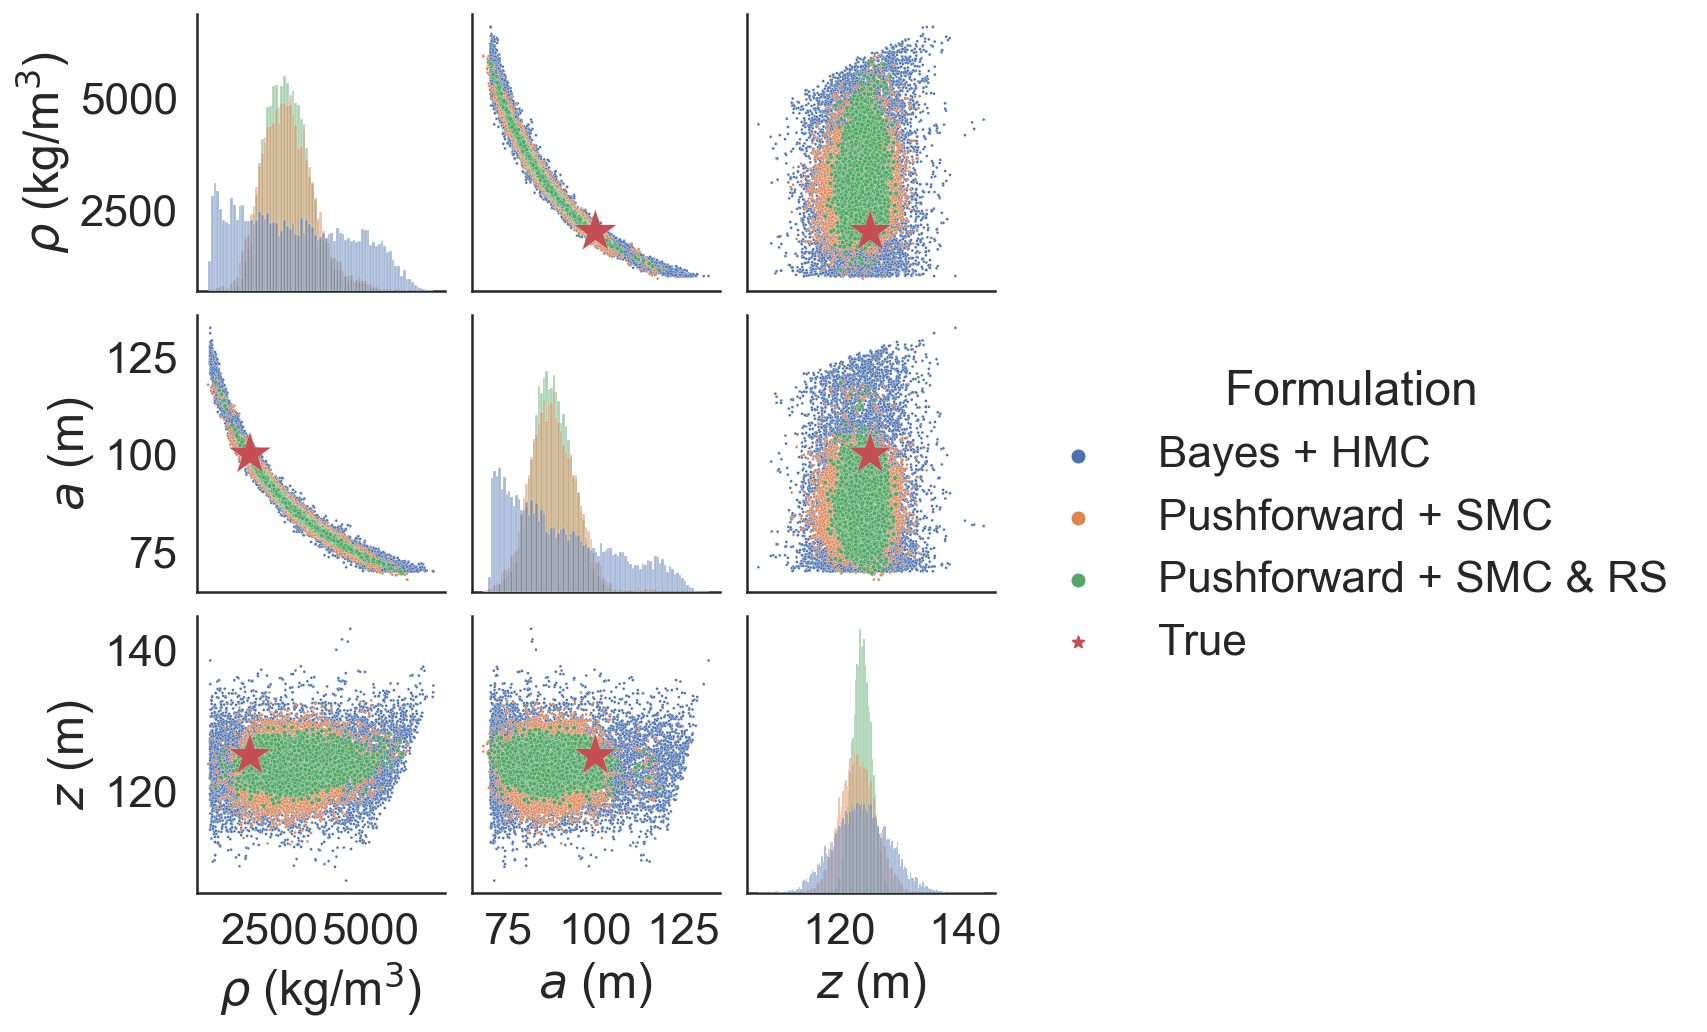

In [13]:
mcmc_samples_df = pd.read_csv('MCMC_samples.csv')

combined = pd.concat([
    mcmc_samples_df.assign(Formulation='Bayes + HMC', size=2, marker='o'),
    posterior_samples_df.assign(Formulation='Pushforward + SMC', size=2, marker='o'),
    final_samples_df.assign(Formulation='Pushforward + SMC & RS', size=5, marker='o'),
    true_df.assign(Formulation='True', size=500, marker='*')  
])
markers2 = {'Pushforward + SMC': 'o', 'Bayes + HMC': 'o', 'True': '*', 'Pushforward + SMC & RS':'o'}

h = sns.pairplot(combined[cols + ['Formulation']], kind = 'scatter', diag_kind='hist', plot_kws={"s": combined['size']}, markers=markers2, hue="Formulation")


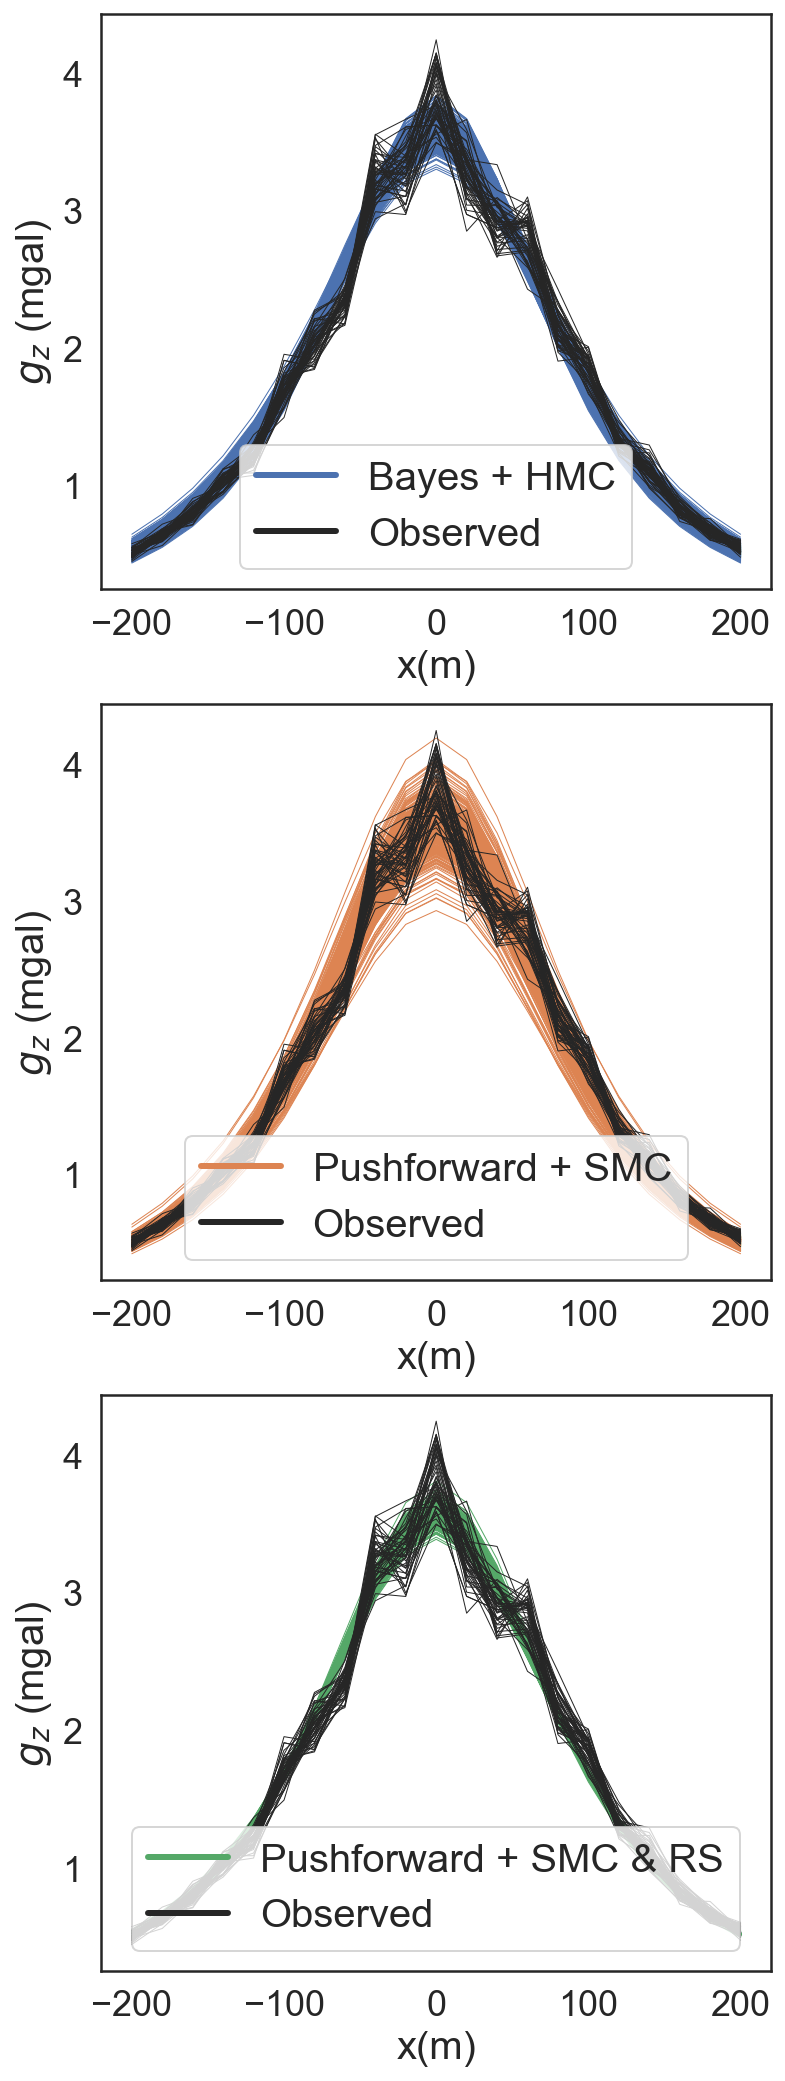

In [14]:
mcmc_data = g(np.fliplr(mcmc_samples_df.values))
it = 2

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6,18))

post_d = S['d_samples'][it]
# post_d = final_data

axs[1].plot(x,post_d[:500,:].T,color= 'C1', linewidth=0.5)
p1 = axs[1].plot(x,post_d[0,:].T,color= 'C1', linewidth=0.5, label='Pushforward + SMC')
axs[1].plot(x,obs_d[:50,:].T,'-',color = [0.15, 0.15, 0.15, 1], linewidth=0.5)
p2 = axs[1].plot(x,obs_d[0,:].T,'-',color = [0.15, 0.15, 0.15, 1], linewidth=0.5, label='Observed')
axs[1].set_xlabel('x(m)', fontsize=fs)
axs[1].set_ylabel(r'$g_z$ (mgal)', fontsize=fs)
# axs[0,0].set_title('Proposal', fontsize=16)
axs[1].tick_params(labelsize=ts)
leg = axs[1].legend(fontsize=fs, loc='lower center')
for L in leg.get_lines():
    L.set_linewidth(3)
    
    
axs[0].plot(x,mcmc_data[:500,:].T,color= 'C0', linewidth=0.5)
p1 = axs[0].plot(x,mcmc_data[0,:].T,color= 'C0', linewidth=0.5, label='Bayes + HMC')
axs[0].plot(x,obs_d[:50,:].T,'-',color = [0.15, 0.15, 0.15, 1], linewidth=0.5)
p2 = axs[0].plot(x,obs_d[0,:].T,'-',color = [0.15, 0.15, 0.15, 1], linewidth=0.5, label='Observed')
axs[0].set_xlabel('x(m)', fontsize=fs)
axs[0].set_ylabel(r'$g_z$ (mgal)', fontsize=fs)
axs[0].tick_params(labelsize=ts)
leg = axs[0].legend(fontsize=fs, loc='lower center')
for L in leg.get_lines():
    L.set_linewidth(3)
    
rej_d = final_data
axs[2].plot(x,rej_d[:500,:].T,color= 'C2', linewidth=0.5)
p1 = axs[2].plot(x,rej_d[0,:].T,color= 'C2', linewidth=0.5, label='Pushforward + SMC & RS')
axs[2].plot(x,obs_d[:50,:].T,'-',color = [0.15, 0.15, 0.15, 1], linewidth=0.5)
p2 = axs[2].plot(x,obs_d[0,:].T,'-',color = [0.15, 0.15, 0.15, 1], linewidth=0.5, label='Observed')
axs[2].set_xlabel('x(m)', fontsize=fs)
axs[2].set_ylabel(r'$g_z$ (mgal)', fontsize=fs)
# axs[0,0].set_title('Proposal', fontsize=16)
axs[2].tick_params(labelsize=ts)
leg = axs[2].legend(fontsize=fs, loc='lower center')
for L in leg.get_lines():
    L.set_linewidth(3)

In [15]:
acc_rate

0.21089